In [1]:
# !pip install catboost librosa resampy soundfile tqdm kagglehub optuna optuna-dashboard

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

# print("Path to dataset files:", path)
# !cp -rf {path} ./dataset

In [3]:
import pandas as pd
import numpy as np
from model import *
from dagxtractor import DAGXtractor, mapper, flat_mapper

In [4]:
import pandas as pd
df = pd.read_csv("dataset/Data/features_30_sec.csv")
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [5]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['label'])  # Features: e.g., 'track' and 'statistics'
y = df['label']  # Target: 'label'

# Split the dataset while preserving class proportions
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y,
    test_size=0.2,  # 20% for testing
    stratify=y,     # Preserve class proportions
    random_state=42 # For reproducibility
)

In [6]:
# Drop corrupted sample
idx = X_train.index[X_train["filename"] == "jazz.00054.wav"]
X_train = X_train.drop(index=idx)
y_train = y_train.drop(index=idx)

In [7]:
model, acc = train_and_evaluate_catboost(
    X_train.drop(columns=["filename", "length"]).to_numpy(),
    y_train.to_numpy(),
)

0:	learn: 0.2989045	total: 63.6ms	remaining: 31.7s
100:	learn: 0.8247261	total: 270ms	remaining: 1.07s
200:	learn: 0.9092332	total: 476ms	remaining: 708ms
300:	learn: 0.9561815	total: 694ms	remaining: 459ms
400:	learn: 0.9812207	total: 900ms	remaining: 222ms
499:	learn: 0.9953052	total: 1.1s	remaining: 0us
0:	learn: 0.3818466	total: 4.29ms	remaining: 2.14s
100:	learn: 0.8356808	total: 217ms	remaining: 856ms
200:	learn: 0.9107981	total: 450ms	remaining: 669ms
300:	learn: 0.9655712	total: 656ms	remaining: 434ms
400:	learn: 0.9859155	total: 864ms	remaining: 213ms
499:	learn: 0.9921753	total: 1.1s	remaining: 0us
0:	learn: 0.3302034	total: 4.24ms	remaining: 2.12s
100:	learn: 0.8325509	total: 241ms	remaining: 951ms
200:	learn: 0.9139280	total: 463ms	remaining: 689ms
300:	learn: 0.9546166	total: 702ms	remaining: 464ms
400:	learn: 0.9796557	total: 954ms	remaining: 235ms
499:	learn: 0.9890454	total: 1.17s	remaining: 0us
0:	learn: 0.3208138	total: 4.48ms	remaining: 2.24s
100:	learn: 0.8435055	to

In [8]:
import soundfile as sf
import librosa
import numpy as np
import resampy

In [9]:
sr = 22050
hop_length = 512
n_mfcc = 20
n_mels = 128
n_bins = 84
bins_per_octave = 12
fmin = librosa.note_to_hz("C1")
fmax = fmin * 2 ** 7
n_fft=2048
mel_proj = librosa.filters.mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax)

class Extractor(DAGXtractor):
    @mapper("audio")
    def load_audio(x) -> [np.ndarray]:
        file_path = f"dataset/Data/genres_original/{x[0].split('.')[0]}/{x[0]}"
        y, sr = sf.read(file_path)
        if len(y.shape) == 2:  # Convert stereo to mono
            y = np.mean(y, dim=0)
        if sr != 22050:
            y = resample(y, sr, 22050)
        return y[:660000].astype('float32') # Sizes of samples slightly differ
    @mapper("stats")
    def stats(x):
        return x[2:-1]
    @mapper("labels")
    def labels(x):
        return x[-1]
    @mapper("rms", batched=True)
    def rms(audio):
        return np.sqrt(np.mean(audio**2, axis=-1))
    @mapper("complex_stft", batched=False, uniform=True)
    def complex_stft(audio):
        return librosa.stft(audio, hop_length=hop_length, n_fft=n_fft)
    @mapper("stft", batched=True)
    def stft(complex_stft):
        return np.abs(complex_stft)
    @mapper("complex_cqt", batched=False, uniform=True)
    def complex_cqt(audio):
        return librosa.cqt(audio, sr=sr, hop_length=hop_length, fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)
    @mapper("cqt", batched=True)
    def cqt(complex_cqt):
        return np.abs(complex_cqt)
    @mapper("mel", batched=False)
    def mel(stft):
        return librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft**2, optimize=True))
    @mapper("mfcc", batched=True)
    def mfcc(audio):
        return librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)

In [10]:
E_train = Extractor(
    x=np.hstack([X_train.to_numpy(), y_train.to_numpy().reshape(-1, 1)]),
)
E_eval = Extractor(
    x=np.hstack([X_eval.to_numpy(), y_eval.to_numpy().reshape(-1, 1)])
)
E_train.full_extract()

Running extractor for features audio at 2025-02-12 23:57:58.613066
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 23:58:01.506023 total running time 0:00:02.892957
Running extractor for features complex_stft at 2025-02-12 23:58:01.506078
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 23:58:13.138223 total running time 0:00:11.632145
Running extractor for features stft at 2025-02-12 23:58:13.138366


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 23:59:09.028830 total running time 0:00:55.890464
Running extractor for features stats at 2025-02-12 23:59:09.029997
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 23:59:09.091298 total running time 0:00:00.061301
Running extractor for features mel at 2025-02-12 23:59:09.091535
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 23:59:23.186478 total running time 0:00:14.094943
Running extractor for features mfcc at 2025-02-12 23:59:23.186660


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 23:59:47.863963 total running time 0:00:24.677303
Running extractor for features labels at 2025-02-12 23:59:47.864378
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 23:59:47.885123 total running time 0:00:00.020745
Running extractor for features rms at 2025-02-12 23:59:47.885188


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 23:59:48.347661 total running time 0:00:00.462473
Running extractor for features complex_cqt at 2025-02-12 23:59:48.347716
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:00:06.948026 total running time 0:00:18.600310
Running extractor for features cqt at 2025-02-13 00:00:06.948146


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:00:08.823984 total running time 0:00:01.875838


In [11]:
def bpm_beat(audio):
    return librosa.beat.beat_track(y=audio, sr=sr, hop_length=hop_length)
Extractor.register_mapper(['bpm', 'beat'], bpm_beat, uniform=False)
# Extractor.register_mapper('bpm', lambda audio: librosa.beat.beat_track(y=audio, sr=sr, hop_length=hop_length)[0])

In [12]:
E_train.soft_extract()

Running extractor for features bpm, beat at 2025-02-13 00:00:08.857112


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:00:46.115215 total running time 0:00:37.258103


In [13]:
def stft_hpss(complex_stft):
    stft_harmonic, stft_percussive = librosa.decompose.hpss(complex_stft)
    return np.abs(stft_harmonic), np.abs(stft_percussive)
Extractor.register_mapper(['stft_harmonic', 'stft_percussive'], stft_hpss)

In [14]:
E_train.soft_extract()

Running extractor for features stft_harmonic, stft_percussive at 2025-02-13 00:00:46.151040
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:32:54.474896 total running time 0:32:08.323856


In [15]:
# We do it in a single run, for optimization purposes
def mel_hpss(stft_harmonic, stft_percussive):
    return (
        np.mean(stft_harmonic),
        np.var(stft_harmonic),
        np.mean(stft_percussive),
        np.var(stft_percussive),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_harmonic**2, optimize=True)),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_percussive**2, optimize=True)),
    )

Extractor.register_mapper(['stft_harmonic_mean', 'stft_harmonic_var', 'stft_percussive_mean', 'stft_percussive_var', 'mel_harmonic', 'mel_percussive'], mel_hpss)
E_train.soft_extract()

Running extractor for features stft_harmonic_mean, stft_harmonic_var, stft_percussive_mean, stft_percussive_var, mel_harmonic, mel_percussive at 2025-02-13 00:32:54.562241
Failed compiling function, will use plain python wrapper, exception: tuple index out of range


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:33:54.920378 total running time 0:01:00.358137


In [16]:
Extractor.register_mapper(['cqt_harmonic', 'cqt_percussive'], lambda cqt: librosa.decompose.hpss(cqt))


In [17]:
E_train.soft_extract()

Running extractor for features cqt_harmonic, cqt_percussive at 2025-02-13 00:33:54.957026
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:01.288921 total running time 0:01:06.331895


(0.0, 30.0)

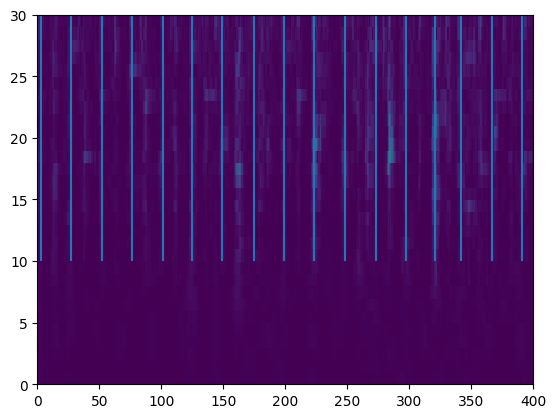

In [18]:
import matplotlib.pyplot as plt
plt.pcolor(next(iter(E_train.features['cqt_percussive']))[0])
plt.vlines(next(iter(E_train.features['beat']))[0], 10, 30)
plt.xlim(0, 400)
plt.ylim(0, 30)

Now lets calculate some basic statistics

In [19]:
Extractor.register_mapper('cqt_mean', lambda cqt: cqt.mean())
Extractor.register_mapper('cqt_var', lambda cqt: cqt.var())
Extractor.register_mapper('cqt_freq_mean', lambda cqt: cqt.mean(axis=1))
Extractor.register_mapper('cqt_freq_var', lambda cqt: cqt.var(axis=1))
Extractor.register_mapper('cqt_harmonic_mean', lambda cqt_harmonic: cqt_harmonic.mean())
Extractor.register_mapper('cqt_harmonic_var', lambda cqt_harmonic: cqt_harmonic.var())
Extractor.register_mapper('cqt_harmonic_freq_mean', lambda cqt_harmonic: cqt_harmonic.mean(axis=1))
Extractor.register_mapper('cqt_harmonic_freq_var', lambda cqt_harmonic: cqt_harmonic.var(axis=1))
Extractor.register_mapper('cqt_percussive_mean', lambda cqt_percussive: cqt_percussive.mean())
Extractor.register_mapper('cqt_percussive_var', lambda cqt_percussive: cqt_percussive.var())
Extractor.register_mapper('cqt_percussive_freq_mean', lambda cqt_percussive: cqt_percussive.mean(axis=1))
Extractor.register_mapper('cqt_percussive_freq_var', lambda cqt_percussive: cqt_percussive.var(axis=1))

# STFT has large resolution (1024 bins per frame),
# yet it is not aligned with how we hear, and lower then CQT for low frequencies.
# So we will project it in MEL bins.
Extractor.register_mapper('stft_mean', lambda stft: stft.mean(axis=1))
Extractor.register_mapper('stft_var', lambda stft: stft.var(axis=1))
Extractor.register_mapper('mel_freq_mean', lambda mel: mel.mean(axis=1))
Extractor.register_mapper('mel_freq_var', lambda mel: mel.var(axis=1))
Extractor.register_mapper('mel_harmonic_freq_mean', lambda mel_harmonic: mel_harmonic.mean(axis=1))
Extractor.register_mapper('mel_harmonic_freq_var', lambda mel_harmonic: mel_harmonic.var(axis=1))
Extractor.register_mapper('mel_percussive_freq_mean', lambda mel_percussive: mel_percussive.mean(axis=1))
Extractor.register_mapper('mel_percussive_freq_var', lambda mel_percussive: mel_percussive.var(axis=1))

In [20]:
E_train.soft_extract()
# E_eval.soft_extract()

Running extractor for features mel_freq_mean at 2025-02-13 00:35:02.986491
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:06.559308 total running time 0:00:03.572817
Running extractor for features cqt_freq_var at 2025-02-13 00:35:06.559343
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:06.757136 total running time 0:00:00.197793
Running extractor for features cqt_harmonic_mean at 2025-02-13 00:35:06.757168
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:06.873645 total running time 0:00:00.116477
Running extractor for features cqt_var at 2025-02-13 00:35:06.873677
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:07.040649 total running time 0:00:00.166972
Running extractor for features cqt_harmonic_freq_mean at 2025-02-13 00:35:07.040681
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:07.186514 total running time 0:00:00.145833
Running extractor for features mel_percussive_freq_var at 2025-02-13 00:35:07.186545
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:07.621182 total running time 0:00:00.434637
Running extractor for features cqt_freq_mean at 2025-02-13 00:35:07.621216
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:07.754682 total running time 0:00:00.133466
Running extractor for features cqt_percussive_freq_var at 2025-02-13 00:35:07.754716
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:07.915161 total running time 0:00:00.160445
Running extractor for features cqt_mean at 2025-02-13 00:35:07.915218
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:08.058879 total running time 0:00:00.143661
Running extractor for features cqt_percussive_var at 2025-02-13 00:35:08.058911
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:08.239342 total running time 0:00:00.180431
Running extractor for features cqt_percussive_mean at 2025-02-13 00:35:08.239376
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:08.401646 total running time 0:00:00.162270
Running extractor for features cqt_percussive_freq_mean at 2025-02-13 00:35:08.401678
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:08.576774 total running time 0:00:00.175096
Running extractor for features cqt_harmonic_var at 2025-02-13 00:35:08.576808
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:08.722072 total running time 0:00:00.145264
Running extractor for features stft_var at 2025-02-13 00:35:08.722121
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:33.005468 total running time 0:00:24.283347
Running extractor for features mel_harmonic_freq_var at 2025-02-13 00:35:33.005565
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:35.287571 total running time 0:00:02.282006
Running extractor for features mel_harmonic_freq_mean at 2025-02-13 00:35:35.287963
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:35.537638 total running time 0:00:00.249675
Running extractor for features cqt_harmonic_freq_var at 2025-02-13 00:35:35.537687
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:35.824894 total running time 0:00:00.287207
Running extractor for features mel_freq_var at 2025-02-13 00:35:35.824941
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:36.056254 total running time 0:00:00.231313
Running extractor for features mel_percussive_freq_mean at 2025-02-13 00:35:36.056289
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:36.241301 total running time 0:00:00.185012
Running extractor for features stft_mean at 2025-02-13 00:35:36.241333
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:35:37.287915 total running time 0:00:01.046582


In [21]:
features = ['cqt_freq_mean', 'cqt_freq_var', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2895149	total: 54.2ms	remaining: 27.1s
100:	learn: 0.7965571	total: 1.77s	remaining: 7s
200:	learn: 0.8748044	total: 3.47s	remaining: 5.16s
300:	learn: 0.9374022	total: 5.13s	remaining: 3.39s
400:	learn: 0.9640063	total: 6.79s	remaining: 1.68s
499:	learn: 0.9874804	total: 8.43s	remaining: 0us
0:	learn: 0.3004695	total: 28.4ms	remaining: 14.2s
100:	learn: 0.7918623	total: 1.71s	remaining: 6.76s
200:	learn: 0.8935837	total: 3.4s	remaining: 5.05s
300:	learn: 0.9264476	total: 5.05s	remaining: 3.34s
400:	learn: 0.9640063	total: 6.7s	remaining: 1.65s
499:	learn: 0.9859155	total: 8.33s	remaining: 0us
0:	learn: 0.3004695	total: 27.9ms	remaining: 13.9s
100:	learn: 0.7809077	total: 1.71s	remaining: 6.74s
200:	learn: 0.8873239	total: 3.37s	remaining: 5.02s
300:	learn: 0.9311424	total: 5.03s	remaining: 3.33s
400:	learn: 0.9640063	total: 6.69s	remaining: 1.65s
499:	learn: 0.9765258	total: 8.32s	remaining: 0us
0:	learn: 0.2456964	total: 27.8ms	remaining: 13.8s
100:	learn: 0.7762128	total

In [22]:
Extractor.register_mapper('mfcc_quef_mean', lambda mfcc: mfcc.mean(axis=1))
Extractor.register_mapper('mfcc_quef_var', lambda mfcc: mfcc.var(axis=1))

# Usually STFT is used for spectral centroid, but I will use CQT, it may turn out to be even more precise.
cqt_frequencies = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)
# Extractor.register_extractor('cqt_spectral_centroid',
#                              lambda cqt: np.sum(cqt_frequencies.reshape(-1, 1) * librosa.util.normalize(cqt, norm=1, axis=0), axis=0))
Extractor.register_mapper('spectral_centroid',
                             lambda audio: librosa.feature.spectral_centroid(y=audio, sr=sr))

Extractor.register_mapper('spectral_centroid_mean', lambda spectral_centroid: spectral_centroid.mean())
Extractor.register_mapper('spectral_centroid_var', lambda spectral_centroid: spectral_centroid.var())

cqt_frequencies = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)
chroma_map = librosa.filters.cq_to_chroma(cqt_frequencies.shape[0], bins_per_octave=bins_per_octave, n_chroma=bins_per_octave, fmin=fmin)
Extractor.register_mapper('cqt_chroma',
                             lambda cqt: librosa.feature.chroma_cqt(C=cqt, sr=sr, hop_length=hop_length, fmin=fmin))
Extractor.register_mapper('cqt_chroma_freq_mean', lambda cqt_chroma: cqt_chroma.mean(axis=1))
Extractor.register_mapper('cqt_chroma_freq_var', lambda cqt_chroma: cqt_chroma.var(axis=1))
Extractor.register_mapper('cqt_chroma_mean', lambda cqt_chroma: cqt_chroma.mean())
Extractor.register_mapper('cqt_chroma_var', lambda cqt_chroma: cqt_chroma.var())

Extractor.register_mapper('cqt_harmonic_chroma',
                             lambda cqt_harmonic: librosa.feature.chroma_cqt(C=cqt_harmonic, sr=sr, hop_length=hop_length, fmin=fmin))
Extractor.register_mapper('cqt_harmonic_chroma_freq_mean', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.mean(axis=1))
Extractor.register_mapper('cqt_harmonic_chroma_freq_var', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.var(axis=1))
Extractor.register_mapper('cqt_harmonic_chroma_mean', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.mean())
Extractor.register_mapper('cqt_harmonic_chroma_var', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.var())

roll_percent = 0.85
# Extractor.register_extractor('cqt_rolloff',
#                              lambda cqt: librosa.feature.spectral.spectral_rolloff(S=cqt, freq=cqt_frequencies, roll_percent=roll_percent))
Extractor.register_mapper('rolloff',
                             lambda stft: librosa.feature.spectral.spectral_rolloff(S=stft, sr=sr, roll_percent=roll_percent))

Extractor.register_mapper('rolloff_mean', lambda rolloff: rolloff.mean())
Extractor.register_mapper('rolloff_var', lambda rolloff: rolloff.var())

# Extractor.register_extractor('cqt_bandwidth',
#                              lambda cqt: librosa.feature.spectral.spectral_bandwidth(S=cqt, freq=cqt_frequencies))
Extractor.register_mapper('bandwidth',
                             lambda stft: librosa.feature.spectral.spectral_bandwidth(S=stft, sr=sr, n_fft=n_fft))

Extractor.register_mapper('bandwidth_mean', lambda bandwidth: bandwidth.mean())
Extractor.register_mapper('bandwidth_var', lambda bandwidth: bandwidth.var())

Extractor.register_mapper('zero_crossing_rate',
                             lambda audio: librosa.feature.zero_crossing_rate(y=audio))

Extractor.register_mapper('zero_crossing_rate_mean', lambda zero_crossing_rate: zero_crossing_rate.mean())
Extractor.register_mapper('zero_crossing_rate_var', lambda zero_crossing_rate: zero_crossing_rate.var())


Extractor.register_mapper('percept', lambda cqt: librosa.perceptual_weighting(cqt**2, cqt_frequencies, ref=np.max))
Extractor.register_mapper('percept_freq_mean', lambda percept: percept.mean(axis=1))
Extractor.register_mapper('percept_freq_var', lambda percept: percept.var(axis=1))
Extractor.register_mapper('percept_mean', lambda percept: percept.mean())
Extractor.register_mapper('percept_var', lambda percept: percept.var())

Extractor.register_mapper('stft_chroma', lambda stft: librosa.feature.chroma_stft(S=stft**2, sr=sr))
Extractor.register_mapper('stft_chroma_freq_mean', lambda stft_chroma: np.mean(stft_chroma, axis=1))
Extractor.register_mapper('stft_chroma_freq_var', lambda stft_chroma: np.var(stft_chroma, axis=1))
Extractor.register_mapper('stft_chroma_mean', lambda stft_chroma: np.mean(stft_chroma))
Extractor.register_mapper('stft_chroma_var', lambda stft_chroma: np.var(stft_chroma))

In [23]:
E_train.soft_extract()
# E_eval.soft_extract()

Running extractor for features zero_crossing_rate at 2025-02-13 00:36:27.904877
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:43.218776 total running time 0:00:15.313899
Running extractor for features zero_crossing_rate_var at 2025-02-13 00:36:43.218821
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:43.437381 total running time 0:00:00.218560
Running extractor for features percept at 2025-02-13 00:36:43.437412
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:46.574967 total running time 0:00:03.137555
Running extractor for features percept_freq_mean at 2025-02-13 00:36:46.575045
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:46.894536 total running time 0:00:00.319491
Running extractor for features cqt_harmonic_chroma at 2025-02-13 00:36:46.894576
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:48.601174 total running time 0:00:01.706598
Running extractor for features cqt_harmonic_chroma_var at 2025-02-13 00:36:48.601263
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:48.974725 total running time 0:00:00.373462
Running extractor for features rolloff at 2025-02-13 00:36:48.974756
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:56.010642 total running time 0:00:07.035886
Running extractor for features rolloff_mean at 2025-02-13 00:36:56.010695
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:56.291189 total running time 0:00:00.280494
Running extractor for features mfcc_quef_var at 2025-02-13 00:36:56.291224
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:57.158549 total running time 0:00:00.867325
Running extractor for features percept_mean at 2025-02-13 00:36:57.158586
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:57.405909 total running time 0:00:00.247323
Running extractor for features zero_crossing_rate_mean at 2025-02-13 00:36:57.405941
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:36:57.575072 total running time 0:00:00.169131
Running extractor for features stft_chroma at 2025-02-13 00:36:57.575103
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:21.995553 total running time 0:00:24.420450
Running extractor for features cqt_harmonic_chroma_mean at 2025-02-13 00:37:21.995644
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:22.337376 total running time 0:00:00.341732
Running extractor for features cqt_chroma at 2025-02-13 00:37:22.337414
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:24.678160 total running time 0:00:02.340746
Running extractor for features cqt_chroma_freq_mean at 2025-02-13 00:37:24.678244
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:25.146585 total running time 0:00:00.468341
Running extractor for features cqt_chroma_var at 2025-02-13 00:37:25.146622
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:25.492376 total running time 0:00:00.345754
Running extractor for features bandwidth at 2025-02-13 00:37:25.492416
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:39.452647 total running time 0:00:13.960231
Running extractor for features bandwidth_var at 2025-02-13 00:37:39.452695
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:39.797316 total running time 0:00:00.344621
Running extractor for features spectral_centroid at 2025-02-13 00:37:39.797351
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:53.700632 total running time 0:00:13.903281
Running extractor for features spectral_centroid_mean at 2025-02-13 00:37:53.700671
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:54.056897 total running time 0:00:00.356226
Running extractor for features rolloff_var at 2025-02-13 00:37:54.056930
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:54.236181 total running time 0:00:00.179251
Running extractor for features cqt_chroma_mean at 2025-02-13 00:37:54.236216
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:54.521435 total running time 0:00:00.285219
Running extractor for features stft_chroma_mean at 2025-02-13 00:37:54.521470
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:54.757894 total running time 0:00:00.236424
Running extractor for features percept_var at 2025-02-13 00:37:54.757937
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:55.060717 total running time 0:00:00.302780
Running extractor for features percept_freq_var at 2025-02-13 00:37:55.060750
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:55.568105 total running time 0:00:00.507355
Running extractor for features cqt_chroma_freq_var at 2025-02-13 00:37:55.568146
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:55.916502 total running time 0:00:00.348356
Running extractor for features mfcc_quef_mean at 2025-02-13 00:37:55.916551
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:56.109782 total running time 0:00:00.193231
Running extractor for features stft_chroma_var at 2025-02-13 00:37:56.109814
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:56.443965 total running time 0:00:00.334151
Running extractor for features spectral_centroid_var at 2025-02-13 00:37:56.444003
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:56.740021 total running time 0:00:00.296018
Running extractor for features stft_chroma_freq_mean at 2025-02-13 00:37:56.740059
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:57.100838 total running time 0:00:00.360779
Running extractor for features cqt_harmonic_chroma_freq_mean at 2025-02-13 00:37:57.100870
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:57.305777 total running time 0:00:00.204907
Running extractor for features stft_chroma_freq_var at 2025-02-13 00:37:57.305807
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:57.675592 total running time 0:00:00.369785
Running extractor for features cqt_harmonic_chroma_freq_var at 2025-02-13 00:37:57.675623
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:58.045672 total running time 0:00:00.370049
Running extractor for features bandwidth_mean at 2025-02-13 00:37:58.045711
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:37:58.272155 total running time 0:00:00.226444


In [24]:
features = ['rms', 'bpm',
    'cqt_freq_mean', 'cqt_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.3067293	total: 119ms	remaining: 59.2s
100:	learn: 0.8669797	total: 2.74s	remaining: 10.8s
200:	learn: 0.9405321	total: 5.21s	remaining: 7.75s
300:	learn: 0.9733959	total: 7.72s	remaining: 5.11s
400:	learn: 0.9906103	total: 10.2s	remaining: 2.51s
499:	learn: 0.9968701	total: 12.6s	remaining: 0us
0:	learn: 0.3255086	total: 41.6ms	remaining: 20.8s
100:	learn: 0.8685446	total: 2.59s	remaining: 10.3s
200:	learn: 0.9405321	total: 5.07s	remaining: 7.54s
300:	learn: 0.9765258	total: 7.53s	remaining: 4.98s
400:	learn: 0.9874804	total: 10s	remaining: 2.47s
499:	learn: 0.9937402	total: 12.4s	remaining: 0us
0:	learn: 0.2957746	total: 41.8ms	remaining: 20.8s
100:	learn: 0.8669797	total: 2.7s	remaining: 10.7s
200:	learn: 0.9420970	total: 5.16s	remaining: 7.67s
300:	learn: 0.9718310	total: 7.67s	remaining: 5.07s
400:	learn: 0.9890454	total: 10.2s	remaining: 2.51s
499:	learn: 0.9921753	total: 12.6s	remaining: 0us
0:	learn: 0.3114241	total: 42.4ms	remaining: 21.2s
100:	learn: 0.8450704	tota

In [25]:
features = ['rms', 'bpm',
    'mel_freq_mean', 'mel_freq_var',
    'stft_harmonic_mean', 'mel_harmonic_freq_mean', 'mel_harmonic_freq_var',
    'stft_percussive_mean', 'mel_percussive_freq_mean', 'mel_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2926448	total: 71.3ms	remaining: 35.6s
100:	learn: 0.8669797	total: 3.68s	remaining: 14.5s
200:	learn: 0.9436620	total: 7.06s	remaining: 10.5s
300:	learn: 0.9796557	total: 10.4s	remaining: 6.89s
400:	learn: 0.9921753	total: 13.8s	remaining: 3.4s
499:	learn: 0.9984351	total: 17.1s	remaining: 0us
0:	learn: 0.3286385	total: 60.5ms	remaining: 30.2s
100:	learn: 0.8482003	total: 3.5s	remaining: 13.8s
200:	learn: 0.9452269	total: 6.89s	remaining: 10.3s
300:	learn: 0.9687011	total: 10.3s	remaining: 6.78s
400:	learn: 0.9906103	total: 13.6s	remaining: 3.36s
499:	learn: 0.9953052	total: 16.9s	remaining: 0us
0:	learn: 0.3442879	total: 55.4ms	remaining: 27.6s
100:	learn: 0.8575900	total: 3.52s	remaining: 13.9s
200:	learn: 0.9327074	total: 6.89s	remaining: 10.2s
300:	learn: 0.9671362	total: 10.2s	remaining: 6.77s
400:	learn: 0.9874804	total: 13.6s	remaining: 3.35s
499:	learn: 0.9921753	total: 17s	remaining: 0us
0:	learn: 0.3082942	total: 59.4ms	remaining: 29.6s
100:	learn: 0.8153365	tota

In [26]:
n_mels = 48
mel_proj = librosa.filters.mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax, n_mels=n_mels)

In [27]:
Extractor.register_mapper('mel48', lambda stft: librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft**2, optimize=True)))
def mel_hpss(stft_harmonic, stft_percussive):
    return (
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_harmonic**2, optimize=True)),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_percussive**2, optimize=True)),
    )

Extractor.register_mapper(['mel48_harmonic', 'mel48_percussive'], mel_hpss)
E_train.soft_extract()

Running extractor for features mel48 at 2025-02-13 00:41:02.654787
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:41:08.224053 total running time 0:00:05.569266
Running extractor for features mel48_harmonic, mel48_percussive at 2025-02-13 00:41:08.224240
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:42:12.653492 total running time 0:01:04.429252


In [28]:
Extractor.register_mapper('mel48_freq_mean', lambda mel48: mel48.mean(axis=1))
Extractor.register_mapper('mel48_freq_var', lambda mel48: mel48.var(axis=1))
Extractor.register_mapper('mel48_harmonic_freq_mean', lambda mel48_harmonic: mel48_harmonic.mean(axis=1))
Extractor.register_mapper('mel48_harmonic_freq_var', lambda mel48_harmonic: mel48_harmonic.var(axis=1))
Extractor.register_mapper('mel48_percussive_freq_mean', lambda mel48_percussive: mel48_percussive.mean(axis=1))
Extractor.register_mapper('mel48_percussive_freq_var', lambda mel48_percussive: mel48_percussive.var(axis=1))
E_train.soft_extract()

Running extractor for features mel48_percussive_freq_mean at 2025-02-13 00:42:12.683986
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:42:12.853746 total running time 0:00:00.169760
Running extractor for features mel48_freq_mean at 2025-02-13 00:42:12.853840
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:42:13.942109 total running time 0:00:01.088269
Running extractor for features mel48_harmonic_freq_var at 2025-02-13 00:42:13.942145
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:42:14.074150 total running time 0:00:00.132005
Running extractor for features mel48_freq_var at 2025-02-13 00:42:14.074182
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:42:14.188830 total running time 0:00:00.114648
Running extractor for features mel48_percussive_freq_var at 2025-02-13 00:42:14.188862
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:42:14.286335 total running time 0:00:00.097473
Running extractor for features mel48_harmonic_freq_mean at 2025-02-13 00:42:14.286374
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:42:14.357873 total running time 0:00:00.071499


In [29]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'stft_harmonic_mean', 'mel48_harmonic_freq_mean', 'mel48_harmonic_freq_var',
    'stft_percussive_mean', 'mel48_percussive_freq_mean', 'mel48_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2863850	total: 60.1ms	remaining: 30s
100:	learn: 0.8607199	total: 2.02s	remaining: 8s
200:	learn: 0.9327074	total: 4.06s	remaining: 6.03s
300:	learn: 0.9718310	total: 5.93s	remaining: 3.92s
400:	learn: 0.9874804	total: 7.79s	remaining: 1.92s
499:	learn: 0.9984351	total: 9.66s	remaining: 0us
0:	learn: 0.2989045	total: 30.5ms	remaining: 15.2s
100:	learn: 0.8748044	total: 1.94s	remaining: 7.68s
200:	learn: 0.9327074	total: 3.77s	remaining: 5.61s
300:	learn: 0.9733959	total: 5.63s	remaining: 3.72s
400:	learn: 0.9859155	total: 7.49s	remaining: 1.85s
499:	learn: 0.9921753	total: 9.3s	remaining: 0us
0:	learn: 0.2989045	total: 30.7ms	remaining: 15.3s
100:	learn: 0.8528951	total: 1.92s	remaining: 7.59s
200:	learn: 0.9342723	total: 3.74s	remaining: 5.57s
300:	learn: 0.9733959	total: 5.61s	remaining: 3.71s
400:	learn: 0.9843505	total: 7.54s	remaining: 1.86s
499:	learn: 0.9921753	total: 9.36s	remaining: 0us
0:	learn: 0.2942097	total: 31.2ms	remaining: 15.6s
100:	learn: 0.8528951	total:

In [30]:
pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
mfcc_quef_mean_3,2.604016
mfcc_quef_mean_5,2.526090
bandwidth_mean,2.522673
mel48_percussive_freq_var_1,2.423438
mel48_percussive_freq_var_0,2.334968
mfcc_quef_var_4,2.315471
rms,1.781317
spectral_centroid_var,1.599715
percept_freq_var_1,1.565962
mfcc_quef_mean_8,1.362403


In [31]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.3145540	total: 42.6ms	remaining: 21.3s
100:	learn: 0.8560250	total: 2.48s	remaining: 9.79s
200:	learn: 0.9483568	total: 4.77s	remaining: 7.09s
300:	learn: 0.9733959	total: 7.03s	remaining: 4.65s
400:	learn: 0.9921753	total: 9.3s	remaining: 2.3s
499:	learn: 1.0000000	total: 11.5s	remaining: 0us
0:	learn: 0.2989045	total: 38.3ms	remaining: 19.1s
100:	learn: 0.8638498	total: 2.37s	remaining: 9.37s
200:	learn: 0.9436620	total: 4.66s	remaining: 6.92s
300:	learn: 0.9671362	total: 6.95s	remaining: 4.59s
400:	learn: 0.9874804	total: 9.2s	remaining: 2.27s
499:	learn: 0.9906103	total: 11.4s	remaining: 0us
0:	learn: 0.2879499	total: 39.8ms	remaining: 19.8s
100:	learn: 0.8544601	total: 2.38s	remaining: 9.41s
200:	learn: 0.9327074	total: 4.66s	remaining: 6.93s
300:	learn: 0.9608764	total: 6.94s	remaining: 4.59s
400:	learn: 0.9812207	total: 9.21s	remaining: 2.27s
499:	learn: 0.9953052	total: 11.4s	remaining: 0us
0:	learn: 0.2973396	total: 39.3ms	remaining: 19.6s
100:	learn: 0.8435055	tot

In [32]:
pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
cqt_percussive_freq_var_5,2.752950
mfcc_quef_var_4,1.861032
rolloff_var,1.830884
mfcc_quef_mean_3,1.636252
cqt_percussive_freq_var_24,1.595311
mfcc_quef_mean_5,1.549922
cqt_percussive_freq_var_28,1.436959
mfcc_quef_mean_8,1.400779
bandwidth_mean,1.386569
percept_freq_mean_64,1.369409


In [33]:
pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
).sort_values(by='importance', ascending=True).head(30)

,importance
rms,0.0
cqt_percussive_freq_mean_67,0.0
cqt_percussive_freq_mean_66,0.0
cqt_percussive_freq_mean_63,0.0
cqt_percussive_freq_mean_62,0.0
cqt_percussive_freq_mean_61,0.0
cqt_percussive_freq_mean_60,0.0
cqt_percussive_freq_mean_59,0.0
cqt_percussive_freq_mean_58,0.0
cqt_percussive_freq_mean_57,0.0


In [34]:
df = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
)
df.loc[pd.Series(df.index, index=df.index).apply(lambda x: x.startswith('cqt_percussive'))].sort_values('importance', ascending=False).head(30)

,importance
cqt_percussive_freq_var_5,2.752950
cqt_percussive_freq_var_24,1.595311
cqt_percussive_freq_var_28,1.436959
cqt_percussive_freq_mean_14,1.207290
cqt_percussive_freq_var_20,0.892143
cqt_percussive_freq_var_29,0.867401
cqt_percussive_freq_var_36,0.785187
cqt_percussive_freq_mean_30,0.703420
cqt_percussive_freq_var_23,0.654190
cqt_percussive_freq_var_26,0.637286


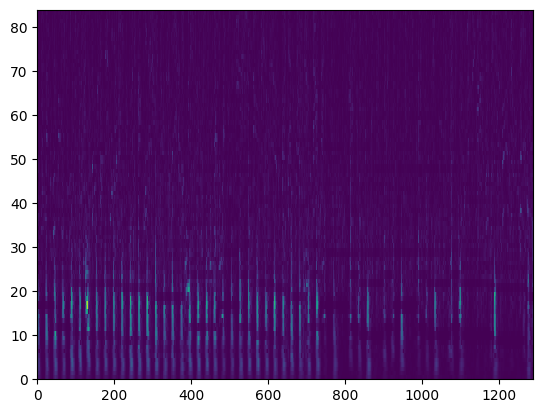

In [35]:
import matplotlib.pyplot as plt
i = iter(E_train.features['cqt_percussive'])
next(i)
plt.pcolor(next(i)[0])

In [36]:
# import importlib
# train_and_evaluate_catboost = importlib.reload(importlib.import_module("model")).train_and_evaluate_catboost

In [37]:
# import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# features = ['rms', 'bpm',
#     'mel48_freq_mean', 'mel48_freq_var',
#     'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
#     'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
#     'mfcc_quef_mean', 'mfcc_quef_var',
#     'spectral_centroid_mean', 'spectral_centroid_var',
#     'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
#     'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
#     'rolloff_mean', 'rolloff_var',
#     'bandwidth_mean', 'bandwidth_var',
#     'percept_freq_mean', 'percept_freq_var',
#     'zero_crossing_rate_mean']

# all_features = ['rms', 'bpm',
#     'mel_freq_mean', 'mel_freq_var',
#     'mel48_freq_mean', 'mel48_freq_var',
#     'cqt_freq_mean', 'cqt_freq_var',
#     'stft_harmonic_mean', 'stft_harmonic_var', 'mel_harmonic_freq_mean', 'mel_harmonic_freq_var', 'mel48_harmonic_freq_mean', 'mel48_harmonic_freq_var',
#     'cqt_harmonic_mean', 'cqt_harmonic_var', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
#     'stft_percussive_mean', 'stft_percussive_var', 'mel_percussive_freq_mean', 'mel_percussive_freq_var', 'mel48_percussive_freq_mean', 'mel48_percussive_freq_var',
#     'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
#     'mfcc_quef_mean', 'mfcc_quef_var',
#     'spectral_centroid_mean', 'spectral_centroid_var',
#     'stft_chroma_mean', 'stft_chroma_var', 'stft_chroma_freq_mean', 'stft_chroma_freq_var',
#     'cqt_chroma_mean', 'cqt_chroma_var', 'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
#     'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
#     'rolloff_mean', 'rolloff_var',
#     'bandwidth_mean', 'bandwidth_var',
#     'percept_freq_mean', 'percept_freq_var',
#     'zero_crossing_rate_mean', 'zero_crossing_rate_var']

# def objective(trial, X, y, column_names):
#     num_features = X.shape[1]
#     selected_features = [trial.suggest_categorical(column_names[i], [0, 1]) for i in range(num_features)]
#     selected_features = np.array(selected_features, dtype=bool)
    
#     if np.sum(selected_features) == 0:
#         return 0  # Avoid empty feature selection

#     X = X[:, selected_features]
    
#     _, acc = train_and_evaluate_catboost(X, y, verbose=False, train_final=False)
#     return acc

# def feature_selection_with_optuna(X, y, column_names, initial_features, n_trials=50):
#     study = optuna.create_study(direction='maximize', storage="sqlite:///optuna.db")
#     if initial_features is not None:
#         initial_params = {c: int(c in initial_features) for c in column_names}
#         study.enqueue_trial(initial_params)
#     study.optimize(lambda trial: objective(trial, X, y, column_names), n_trials=n_trials)
    
#     best_features = [i for i in range(X.shape[1]) if study.best_trial.params.get(column_names[i], 0) == 1]
#     return best_features, study.best_value

# best_features, best_value = feature_selection_with_optuna(
#     E_train.numpy(all_features),
#     y_train.to_numpy(),
#     column_names=E_train.get_columns(all_features),
#     initial_features=E_train.get_columns(features)
# )

In [38]:
imp = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
)
bad_feats = list(imp[imp['importance'] < 0.1].index)

In [39]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3239437	total: 13.6ms	remaining: 6.79s
100:	learn: 0.8669797	total: 802ms	remaining: 3.17s
200:	learn: 0.9546166	total: 1.58s	remaining: 2.35s
300:	learn: 0.9702660	total: 2.35s	remaining: 1.55s
400:	learn: 0.9906103	total: 3.11s	remaining: 769ms
499:	learn: 0.9968701	total: 3.9s	remaining: 0us
0:	learn: 0.3505477	total: 13.4ms	remaining: 6.71s
100:	learn: 0.8810642	total: 810ms	remaining: 3.2s
200:	learn: 0.9358372	total: 1.59s	remaining: 2.36s
300:	learn: 0.9671362	total: 2.37s	remaining: 1.56s
400:	learn: 0.9812207	total: 3.13s	remaining: 773ms
499:	learn: 0.9906103	total: 3.9s	remaining: 0us
0:	learn: 0.2989045	total: 12.8ms	remaining: 6.39s
100:	learn: 0.8716745	total: 798ms	remaining: 3.15s
200:	learn: 0.9420970	total: 1.57s	remaining: 2.34s
300:	learn: 0.9733959	total: 2.34s	remaining: 1.54s
400:	learn: 0.9859155	total: 3.11s	remaining: 768ms
499:	learn: 0.9921753	total: 3.86s	remaining: 0us
0:	learn: 0.2456964	total: 13.2ms	remaining: 6.59s
100:	learn: 0.8654147	tot

In [40]:
import numpy as np
import librosa

p_pitch_stay=0.6
p_pitch_to_silence=0.3
p_silence_stay=0.8
win_size=3
base_weight=1.0
tri_weight=2.0
energy_scale=0.5
harmonic_weights=[0.8, 0.6, 0.4]
eps=1e-6

import numpy as np
import librosa

def compute_f0_from_cqt(cqt):
    """
    Estimate the fundamental frequency (f0) from a CQT spectrogram using Viterbi decoding,
    incorporating:
      (a) a silence state with frame-dependent observation probability,
      (b) a custom transition matrix with a constant plus triangular smoothing, and
      (c) a harmonic weighting scheme that boosts candidate pitch observations if overtones are present.
    
    Observation probabilities:
      - For each frame, silence probability is computed from the original frame energy as:
            silence_obs_prob = 1/(1 + (frame_energy/energy_scale))
      - For pitch states, the CQT magnitudes are first “boosted” by adding weighted contributions
        from overtones. For each candidate state (bin i with center frequency f[i]):
            weighted_cqt[i,t] = cqt_spec[i,t] + sum_{k=2}^{K} (h[k-2] * cqt_spec[j,t])
        where j is the index whose center frequency is closest to k*f[i] and K is the maximum harmonic
        for which k*f[i] is within the range of cqt_frequencies.
      - The boosted magnitudes for pitch states are normalized per frame and then scaled by (1 – silence_obs_prob[t]).
      - The silence observation probability (computed per frame) is appended as the extra state.
    
    Transition matrix for states:
      - For pitch states (indices 0 to n_bins-1):
           • Self-transition probability is p_pitch_stay.
           • A fixed probability p_pitch_to_silence is allocated for transitions to silence.
           • The remaining mass (1 – p_pitch_stay – p_pitch_to_silence) is distributed among transitions to
             other pitch states using a smoothing function:
               weight(i -> j) = base_weight + (if |i – j| <= win_size then tri_weight * (win_size – |i – j| + 1) else 0)
             (These raw weights are normalized to sum to the available probability mass.)
      - For the silence state (index n_bins):
           • Self-transition probability is p_silence_stay.
           • Transitions from silence to any pitch state are uniform.
    
    Parameters:
        cqt_spec (np.ndarray): 2D array (n_bins x n_frames) with the magnitude CQT spectrogram.
        cqt_frequencies (np.ndarray): 1D array (length n_bins) of center frequencies for the CQT bins.
        p_pitch_stay (float): Probability of remaining in the same pitch state.
        p_pitch_to_silence (float): Probability of transitioning from a pitch state to silence.
        p_silence_stay (float): Self-transition probability for the silence state.
        win_size (int): Window size (in bins) for the triangular smoothing component.
        base_weight (float): Baseline weight for transitions between different pitch states.
        tri_weight (float): Additional weight for transitions to nearby notes within win_size.
        energy_scale (float): Scaling factor for computing silence probability from frame energy.
        harmonic_weights (list of float): List of weights for overtones (starting with the 2nd harmonic).
        eps (float): Small constant to avoid division by zero.
    
    Returns:
        f0 (np.ndarray): 1D array (n_frames) of estimated f0 in Hz (0 for silent frames).
        f0_bins (np.ndarray): 1D array (n_frames) with the index of the chosen pitch bin (-1 for silence).
        voiced (np.ndarray): 1D boolean array (n_frames), True if the frame is voiced.
    """
    n_bins, n_frames = cqt.shape
    n_states = n_bins + 1  # extra state for silence
    silence_state = n_bins

    # --- Compute frame energy and silence observation probability ---
    frame_energy = np.sum(cqt, axis=0)  # energy per frame
    silence_obs_prob = 1.0 / (1.0 + (frame_energy / energy_scale))  # higher when energy is low

    # --- Harmonic weighting of pitch observations ---
    # Create a weighted version of the CQT magnitudes so that each candidate's observation is boosted by its overtones.
    weighted_cqt = np.empty_like(cqt)
    for i in range(n_bins):
        # Start with the fundamental magnitude.
        # weighted_cqt[i, t] = cqt_spec[i, t] plus contributions from overtones.
        weighted = cqt[i, :].copy()
        f0_candidate = cqt_frequencies[i]
        # Iterate over harmonics k=2,3,...
        for k, weight in enumerate(harmonic_weights, start=2):
            f_harm = k * f0_candidate
            # If the harmonic frequency exceeds the max frequency in our CQT, stop.
            if f_harm > cqt_frequencies[-1]:
                break
            # Find the bin whose center frequency is closest to the expected harmonic frequency.
            j = np.argmin(np.abs(cqt_frequencies - f_harm))
            # Add the weighted energy from the overtone.
            weighted += weight * cqt[j, :]
        weighted_cqt[i, :] = weighted
    weighted_cqt = weighted_cqt * np.log(10 + np.arange(n_bins))[:, None]
    # --- Build the observation (emission) probability matrix ---
    # For each frame, normalize the weighted pitch observations.
    sum_weighted = np.sum(weighted_cqt, axis=0, keepdims=True) + eps
    # Pitch observation probabilities scaled by (1 - silence_obs_prob).
    obs_pitch = weighted_cqt / sum_weighted * (1 - silence_obs_prob[None, :])
    # Silence observation probabilities (shape: 1 x n_frames)
    obs_silence = silence_obs_prob[None, :]
    # Combined observation matrix: shape (n_states, n_frames), each column sums to 1.
    obs_probs = np.vstack([obs_pitch, obs_silence])
    
    # --- Build the transition probability matrix ---
    transition = np.zeros((n_states, n_states), dtype=np.float64)
    
    # For each pitch state (indices 0 to n_bins-1):
    for i in range(n_bins):
        # Self-transition: remain on the same note.
        transition[i, i] = p_pitch_stay

        # Compute raw weights for transitions to other pitch states.
        raw_weights = np.zeros(n_bins, dtype=np.float64)
        for j in range(n_bins):
            if j == i:
                continue
            # Distance between candidate states.
            dist = abs(i - j)
            # Triangular component if within win_size.
            if dist <= win_size:
                tri_comp = tri_weight * (win_size - dist + 1)
            else:
                tri_comp = 0.0
            raw_weights[j] = base_weight + tri_comp

        # Total probability mass available for transitions to other pitch states.
        avail_mass = 1 - p_pitch_stay - p_pitch_to_silence
        if raw_weights.sum() > 0:
            raw_weights = raw_weights / raw_weights.sum() * avail_mass
        else:
            raw_weights[:] = avail_mass / (n_bins - 1)
        # Assign probabilities for transitioning from pitch state i to other pitch states.
        for j in range(n_bins):
            if j != i:
                transition[i, j] = raw_weights[j]
        # Transition probability from pitch state i to silence.
        transition[i, silence_state] = p_pitch_to_silence

    # For the silence state:
    # Transition from silence to any pitch state uniformly.
    transition[silence_state, :n_bins] = (1 - p_silence_stay) / n_bins
    # Self-transition for silence.
    transition[silence_state, silence_state] = p_silence_stay

    # --- Run the Viterbi algorithm ---
    # librosa.sequence.viterbi expects 1-normalized probabilities; it will take the logarithm internally.
    best_path = librosa.sequence.viterbi(obs_probs, transition)

    # --- Post-processing: interpret state sequence ---
    # Pitch states are indices 0 ... n_bins-1; silence is indicated by state n_bins.
    voiced = best_path < n_bins
    f0_bins = np.where(voiced, best_path, -1)
    f0 = np.zeros(n_frames, dtype=np.float64)
    f0[voiced] = cqt_frequencies[best_path[voiced]]

    return f0, f0_bins, voiced

In [41]:
f0, f0_bins, voiced = compute_f0_from_cqt(next(iter(E_train.features['cqt']))[0])

In [42]:
# f0_pyin, voiced, _ = librosa.pyin(next(iter(E_train.features['audio']))[0], sr=sr, fmin=fmin, fmax=fmax)

In [43]:
# f0_pyin[~voiced] = -1

In [44]:
# spec.shape

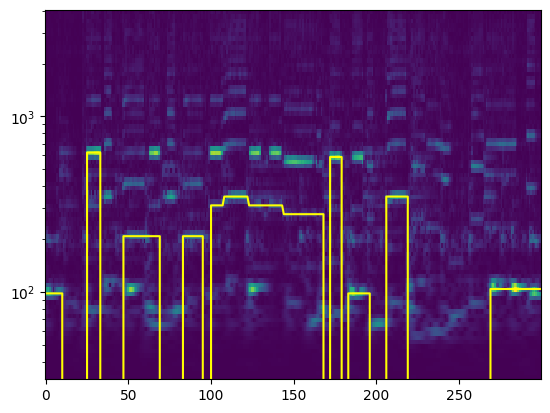

In [46]:
spec = next(iter(E_train.features['cqt']))[0][:,100:400]
x = cqt_frequencies
y = np.arange(spec.shape[1])
xx, yy = np.meshgrid(y, x)
plt.pcolor(xx, yy, spec)
plt.plot(f0[100:400], color='yellow')
# plt.plot(f0_pyin[100:400], color='red')
plt.yscale('log')

In [47]:
Extractor.register_mapper(['f0', 'f0_bins', 'voiced'], compute_f0_from_cqt)
Extractor.register_mapper('f0_mean', lambda f0: np.mean(f0))
Extractor.register_mapper('f0_var', lambda f0: np.var(f0))
Extractor.register_mapper('voiced_f0', lambda f0, voiced: f0[voiced], uniform=False)
Extractor.register_mapper('voiced_f0_bins', lambda f0_bins, voiced: f0_bins[voiced], uniform=False)
Extractor.register_mapper('voiced_f0_mean', lambda f0: np.mean(f0))
Extractor.register_mapper('voiced_f0_var', lambda f0: np.var(f0))
Extractor.register_mapper('voiced_percent', lambda voiced: np.mean(voiced))

In [48]:
E_train.soft_extract()

Running extractor for features f0, f0_bins, voiced at 2025-02-13 00:56:13.229073
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:56:31.211965 total running time 0:00:17.982892
Running extractor for features voiced_f0_mean at 2025-02-13 00:56:31.212004
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:56:31.382483 total running time 0:00:00.170479
Running extractor for features voiced_f0 at 2025-02-13 00:56:31.382528


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:56:31.769481 total running time 0:00:00.386953
Running extractor for features f0_var at 2025-02-13 00:56:31.769513
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:56:31.970220 total running time 0:00:00.200707
Running extractor for features voiced_f0_bins at 2025-02-13 00:56:31.970255


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:56:32.351326 total running time 0:00:00.381071
Running extractor for features f0_mean at 2025-02-13 00:56:32.351354
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:56:32.535995 total running time 0:00:00.184641
Running extractor for features voiced_percent at 2025-02-13 00:56:32.536026
Failed compiling function, will use plain python wrapper.


  0%|          | 0/400 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:56:32.639037 total running time 0:00:00.103011
Running extractor for features voiced_f0_var at 2025-02-13 00:56:32.639065
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:56:32.862281 total running time 0:00:00.223216


In [50]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.2848200	total: 14.8ms	remaining: 7.39s
100:	learn: 0.8669797	total: 886ms	remaining: 3.5s
200:	learn: 0.9436620	total: 1.72s	remaining: 2.55s
300:	learn: 0.9733959	total: 2.56s	remaining: 1.69s
400:	learn: 0.9874804	total: 3.38s	remaining: 834ms
499:	learn: 0.9953052	total: 4.2s	remaining: 0us
0:	learn: 0.3223787	total: 13.5ms	remaining: 6.74s
100:	learn: 0.8732394	total: 862ms	remaining: 3.4s
200:	learn: 0.9327074	total: 1.69s	remaining: 2.51s
300:	learn: 0.9640063	total: 2.52s	remaining: 1.67s
400:	learn: 0.9827856	total: 3.3s	remaining: 815ms
499:	learn: 0.9921753	total: 4.12s	remaining: 0us
0:	learn: 0.3051643	total: 13.3ms	remaining: 6.64s
100:	learn: 0.8654147	total: 863ms	remaining: 3.41s
200:	learn: 0.9389671	total: 1.69s	remaining: 2.51s
300:	learn: 0.9749609	total: 2.57s	remaining: 1.7s
400:	learn: 0.9859155	total: 3.41s	remaining: 841ms
499:	learn: 0.9953052	total: 4.24s	remaining: 0us
0:	learn: 0.2942097	total: 14.1ms	remaining: 7.06s
100:	learn: 0.8544601	total

**ChatGPT query**
Please write a small snippet of code. It should shift CQT spectrogram down based on F0 and crop to 40 frequency bins. F0 is given in Hz, CQT frequencies are in separate array cqt_frequencies

In [51]:
def shift_cqt_by_f0(S: np.ndarray, F0_bins: np.ndarray, voiced: np.ndarray, cqt_frequencies: np.ndarray) -> np.ndarray:
    """
    Shift CQT spectrogram down based on F0 and crop to 40 frequency bins.

    Parameters
    ----------
    S : np.ndarray
        CQT spectrogram, shape (n_freq, n_frames).
    F0 : float
        Fundamental frequency in Hz.
    cqt_frequencies : np.ndarray
        Array of center frequencies for the CQT bins, sorted ascending.

    Returns
    -------
    S_cropped : np.ndarray
        Shifted and cropped CQT spectrogram, shape (40, n_frames).
    """
    # 1. Find which bin is closest to F0
    F0_bins = np.copy(F0_bins)
    F0_bins[~voiced] = 0

    # 2. Shift the spectrogram so that this bin appears near the top
    #    Negative offset rolls elements upward (towards index 0).
    S = np.array([np.roll(frame, -offset) for frame, offset in zip(S.T, F0_bins)]).T
    return S[:40, voiced]

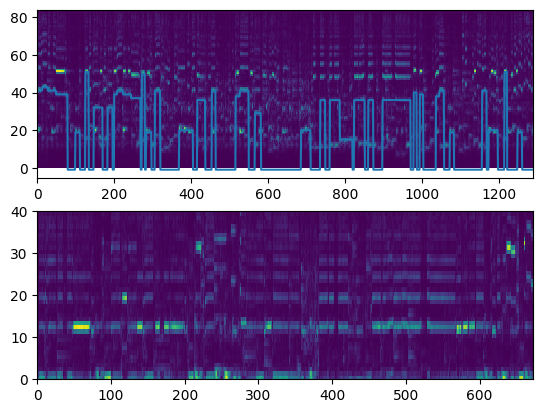

In [52]:
plt.subplot(2, 1, 1)
plt.pcolor(next(iter(E_train.features['cqt']))[0])
plt.plot(next(iter(E_train.features['f0_bins']))[0])
chifted_cqt = shift_cqt_by_f0(next(iter(E_train.features['cqt']))[0],
                              next(iter(E_train.features['f0_bins']))[0],
                              next(iter(E_train.features['voiced']))[0],
                              cqt_frequencies)
plt.subplot(2, 1, 2)
plt.pcolor(chifted_cqt)

In [53]:
Extractor.register_mapper('overtones', lambda cqt, f0_bins, voiced:
                             shift_cqt_by_f0(cqt, f0_bins, voiced, cqt_frequencies), uniform=False)
Extractor.register_mapper('overtones_freq_mean', lambda overtones:
                             np.mean(overtones, axis=1) if overtones.shape[1] > 0 else np.zeros(overtones.shape[0]))
Extractor.register_mapper('overtones_freq_var', lambda overtones:
                             np.var(overtones, axis=1) if overtones.shape[1] > 0 else np.zeros(overtones.shape[0]))

In [54]:
E_train.soft_extract()


Running extractor for features overtones at 2025-02-13 00:57:28.960972


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:57:34.679086 total running time 0:00:05.718114
Running extractor for features overtones_freq_mean at 2025-02-13 00:57:34.679134
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:57:34.930182 total running time 0:00:00.251048
Running extractor for features overtones_freq_var at 2025-02-13 00:57:34.930218
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 00:57:35.219245 total running time 0:00:00.289027


In [55]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'overtones_freq_mean', 'overtones_freq_var']

column_names = E_train.get_columns(features)

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.3098592	total: 81.3ms	remaining: 40.6s
100:	learn: 0.8654147	total: 2.78s	remaining: 11s
200:	learn: 0.9405321	total: 5.67s	remaining: 8.44s
300:	learn: 0.9749609	total: 8.58s	remaining: 5.67s
400:	learn: 0.9874804	total: 11.1s	remaining: 2.75s
499:	learn: 0.9953052	total: 13.6s	remaining: 0us
0:	learn: 0.3223787	total: 43.3ms	remaining: 21.6s
100:	learn: 0.8575900	total: 2.66s	remaining: 10.5s
200:	learn: 0.9420970	total: 5.2s	remaining: 7.74s
300:	learn: 0.9671362	total: 7.74s	remaining: 5.12s
400:	learn: 0.9812207	total: 10.3s	remaining: 2.54s
499:	learn: 0.9859155	total: 12.8s	remaining: 0us
0:	learn: 0.3161189	total: 42.6ms	remaining: 21.3s
100:	learn: 0.8450704	total: 2.63s	remaining: 10.4s
200:	learn: 0.9280125	total: 5.18s	remaining: 7.7s
300:	learn: 0.9687011	total: 7.7s	remaining: 5.09s
400:	learn: 0.9859155	total: 10.2s	remaining: 2.52s
499:	learn: 0.9921753	total: 12.7s	remaining: 0us
0:	learn: 0.3082942	total: 42.5ms	remaining: 21.2s
100:	learn: 0.8669797	total

In [ ]:
# imp = pd.DataFrame(
#     data=model.feature_importances_,
#     index=E_train.get_columns(features),
#     columns=['importance']
# )
# bad_feats = list(imp[imp['importance'] < 0.1].index)

In [ ]:
# features = ['rms', 'bpm', 'zero_crossing_rate_mean',
#     'mel48_freq_mean', 'mel48_freq_var',
#     'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
#     'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
#     'mfcc_quef_mean', 'mfcc_quef_var',
#     'spectral_centroid_mean', 'spectral_centroid_var',
#     'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
#     'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
#     'rolloff_mean', 'rolloff_var',
#     'bandwidth_mean', 'bandwidth_var',
#     'percept_freq_mean', 'percept_freq_var',
#     'zero_crossing_rate_mean',
#     'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
#     'overtones_freq_mean', 'overtones_freq_var']

# column_names = E_train.get_columns(features)
# mask = np.array([x not in bad_feats for x in column_names])

# model, acc = train_and_evaluate_catboost(
#     X=E_train.numpy(features)[:, mask],
#     y=y_train.to_numpy(),
# )

In [56]:
# Extractor.register_mapper('f0_chroma', lambda voiced_f0_bins: voiced_f0_bins % 12, uniform=False)

# def f0_chroma_stats(f0_chroma):
#     if f0_chroma.shape[0] == 0:
#         return 0, 0
#     ohe = np.zeros((12, f0_chroma.shape[0]))
#     ohe[f0_chroma, np.arange(f0_chroma.shape[0])] = 1
#     return (
#         ohe.mean(axis=-1),
#         ohe.var(axis=-1)
#     )
# Extractor.register_mapper(['f0_chroma_freq_mean', 'f0_chroma_freq_var'], f0_chroma_stats)

def f0_chroma_shifted_stats(voiced_f0_bins):
    if voiced_f0_bins.shape[0] == 0:
        return np.zeros((12,)), np.zeros((12,))
    ohe = np.zeros((cqt_frequencies.shape[0], voiced_f0_bins.shape[0]))
    ohe[voiced_f0_bins, np.arange(voiced_f0_bins.shape[0])] = 1
    mean = ohe.mean(axis=-1)
    # plt.pcolor(ohe)
    key = np.argmax(mean)
    key %= 12
    ohe = np.zeros((12, voiced_f0_bins.shape[0]))
    ohe[voiced_f0_bins % 12, np.arange(voiced_f0_bins.shape[0])] = 1
    return (
        np.roll(ohe.mean(axis=-1), -key),
        np.roll(ohe.var(axis=-1), -key),
    )

Extractor.register_mapper(['f0_chroma_shifted_freq_mean', 'f0_chroma_shifted_freq_var'], f0_chroma_shifted_stats)
    
# E_train.soft_extract()

In [57]:
E_train.soft_extract()

Running extractor for features f0_chroma_shifted_freq_mean, f0_chroma_shifted_freq_var at 2025-02-13 01:00:01.124738
Failed compiling function, will use plain python wrapper, exception: Can't vectorize function with more then one return statement, yet.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 01:00:01.356711 total running time 0:00:00.231973


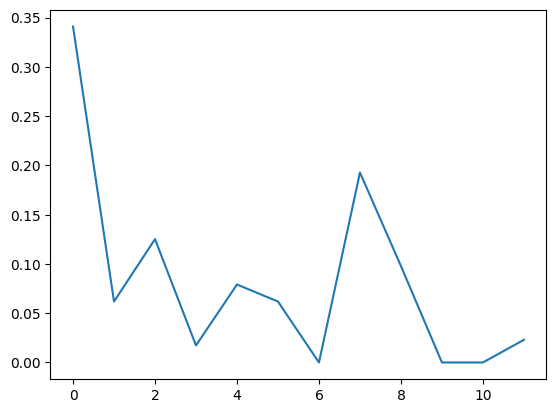

In [58]:
plt.plot(f0_chroma_shifted_stats(E_train.features['voiced_f0_bins']._data[4][0])[0])

In [59]:
features = ['f0_chroma_shifted_freq_mean', 'f0_chroma_shifted_freq_var']

column_names = E_train.get_columns(features)
# mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2206573	total: 2.08ms	remaining: 1.04s
100:	learn: 0.4992175	total: 120ms	remaining: 473ms
200:	learn: 0.5774648	total: 240ms	remaining: 357ms
300:	learn: 0.6541471	total: 357ms	remaining: 236ms
400:	learn: 0.6964006	total: 473ms	remaining: 117ms
499:	learn: 0.7480438	total: 587ms	remaining: 0us
0:	learn: 0.2237872	total: 1.23ms	remaining: 612ms
100:	learn: 0.5211268	total: 115ms	remaining: 455ms
200:	learn: 0.6103286	total: 240ms	remaining: 357ms
300:	learn: 0.6635368	total: 359ms	remaining: 237ms
400:	learn: 0.7230047	total: 484ms	remaining: 119ms
499:	learn: 0.7746479	total: 607ms	remaining: 0us
0:	learn: 0.2222222	total: 1.24ms	remaining: 619ms
100:	learn: 0.5352113	total: 114ms	remaining: 452ms
200:	learn: 0.6056338	total: 226ms	remaining: 336ms
300:	learn: 0.6776213	total: 337ms	remaining: 223ms
400:	learn: 0.7167449	total: 448ms	remaining: 111ms
499:	learn: 0.7668232	total: 559ms	remaining: 0us
0:	learn: 0.2237872	total: 1.33ms	remaining: 662ms
100:	learn: 0.5133020	

In [61]:
# features = ['f0_chroma_freq_mean', 'f0_chroma_freq_var']

# column_names = E_train.get_columns(features)
# mask = np.array([x not in bad_feats for x in column_names])

# model, acc = train_and_evaluate_catboost(
#     X=E_train.numpy(features)[:, mask],
#     y=y_train.to_numpy(),
# )

In [62]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'f0_chroma_shifted_freq_mean', 'f0_chroma_shifted_freq_var']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3333333	total: 30ms	remaining: 14.9s
100:	learn: 0.8654147	total: 973ms	remaining: 3.85s
200:	learn: 0.9546166	total: 1.85s	remaining: 2.75s
300:	learn: 0.9780908	total: 2.72s	remaining: 1.8s
400:	learn: 0.9890454	total: 3.58s	remaining: 883ms
499:	learn: 0.9968701	total: 4.43s	remaining: 0us
0:	learn: 0.3270736	total: 14.5ms	remaining: 7.22s
100:	learn: 0.8701095	total: 922ms	remaining: 3.64s
200:	learn: 0.9452269	total: 1.81s	remaining: 2.69s
300:	learn: 0.9671362	total: 2.66s	remaining: 1.76s
400:	learn: 0.9890454	total: 3.52s	remaining: 869ms
499:	learn: 0.9921753	total: 4.36s	remaining: 0us
0:	learn: 0.3082942	total: 14.3ms	remaining: 7.12s
100:	learn: 0.8794992	total: 890ms	remaining: 3.52s
200:	learn: 0.9436620	total: 1.76s	remaining: 2.62s
300:	learn: 0.9765258	total: 2.61s	remaining: 1.72s
400:	learn: 0.9906103	total: 3.47s	remaining: 856ms
499:	learn: 0.9984351	total: 4.31s	remaining: 0us
0:	learn: 0.2832551	total: 14.2ms	remaining: 7.1s
100:	learn: 0.8904538	tota

In [63]:
pd.DataFrame(
    data=model.feature_importances_,
    index=np.array(E_train.get_columns(features))[mask],
    columns=['importance']
).sort_values('importance', ascending=False).head(30)

,importance
mfcc_quef_mean_3,3.254400
bandwidth_mean,3.069062
mfcc_quef_var_4,2.931473
cqt_harmonic_freq_var_10,2.365524
mfcc_quef_mean_5,2.317102
cqt_percussive_freq_var_33,1.996789
mel48_freq_var_35,1.830703
cqt_harmonic_freq_var_33,1.824305
cqt_percussive_freq_mean_19,1.783911
cqt_percussive_freq_var_25,1.507354


In [64]:
new = E_train.get_columns(['f0_chroma_shifted_freq_mean', 'f0_chroma_shifted_freq_var'])
pd.DataFrame(
    data=model.feature_importances_,
    index=np.array(E_train.get_columns(features))[mask],
    columns=['importance']
).loc[new]

,importance
f0_chroma_shifted_freq_mean_0,0.340320
f0_chroma_shifted_freq_mean_1,0.094853
f0_chroma_shifted_freq_mean_2,0.049555
f0_chroma_shifted_freq_mean_3,0.000315
f0_chroma_shifted_freq_mean_4,0.028165
f0_chroma_shifted_freq_mean_5,1.090288
f0_chroma_shifted_freq_mean_6,0.183776
f0_chroma_shifted_freq_mean_7,0.602871
f0_chroma_shifted_freq_mean_8,0.065165
f0_chroma_shifted_freq_mean_9,0.005917


In [67]:
bad_feats += list(set(new) - {'f0_chroma_shifted_freq_mean_5', 'f0_chroma_shifted_freq_mean_7'})

In [71]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3129890	total: 25.4ms	remaining: 12.7s
100:	learn: 0.8810642	total: 908ms	remaining: 3.59s
200:	learn: 0.9514867	total: 1.78s	remaining: 2.64s
300:	learn: 0.9796557	total: 2.66s	remaining: 1.76s
400:	learn: 0.9921753	total: 3.54s	remaining: 874ms
499:	learn: 1.0000000	total: 4.35s	remaining: 0us
0:	learn: 0.3004695	total: 13.5ms	remaining: 6.75s
100:	learn: 0.8951487	total: 880ms	remaining: 3.47s
200:	learn: 0.9436620	total: 1.76s	remaining: 2.62s
300:	learn: 0.9702660	total: 2.62s	remaining: 1.73s
400:	learn: 0.9874804	total: 3.42s	remaining: 846ms
499:	learn: 0.9890454	total: 4.23s	remaining: 0us
0:	learn: 0.2910798	total: 13.5ms	remaining: 6.74s
100:	learn: 0.8732394	total: 861ms	remaining: 3.4s
200:	learn: 0.9499218	total: 1.76s	remaining: 2.61s
300:	learn: 0.9718310	total: 2.6s	remaining: 1.72s
400:	learn: 0.9890454	total: 3.4s	remaining: 840ms
499:	learn: 0.9937402	total: 4.2s	remaining: 0us
0:	learn: 0.2926448	total: 13.3ms	remaining: 6.63s
100:	learn: 0.8622848	tota

In [91]:
# Extractor.register_mapper('tempogram', lambda audio: librosa.feature.tempogram(y=audio, sr=sr, hop_length=hop_length))
# Extractor.register_mapper('tempogram_tempo_mean', lambda tempogram: tempogram.mean(axis=-1))
# Extractor.register_mapper('tempogram_tempo_var', lambda tempogram: tempogram.var(axis=-1))
Extractor.register_mapper('tempogram_ratio', lambda tempogram: librosa.feature.tempogram_ratio(tg=tempogram, sr=sr))
Extractor.register_mapper('tempogram_ratio_tempo_mean', lambda tempogram_ratio: tempogram_ratio.mean(axis=-1))
Extractor.register_mapper('tempogram_ratio_tempo_var', lambda tempogram_ratio: tempogram_ratio.var(axis=-1))
E_train.soft_extract()

Running extractor for features tempogram_ratio at 2025-02-13 01:29:57.699797
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 01:30:18.428817 total running time 0:00:20.729020
Running extractor for features tempogram_ratio_tempo_mean at 2025-02-13 01:30:18.428857
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 01:30:18.746422 total running time 0:00:00.317565
Running extractor for features tempogram_ratio_tempo_var at 2025-02-13 01:30:18.746463
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-13 01:30:19.085026 total running time 0:00:00.338563


In [92]:
features = [
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var'
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.1893584	total: 2.81ms	remaining: 1.4s
100:	learn: 0.5352113	total: 135ms	remaining: 535ms
200:	learn: 0.6369327	total: 258ms	remaining: 384ms
300:	learn: 0.7104851	total: 378ms	remaining: 250ms
400:	learn: 0.7871674	total: 498ms	remaining: 123ms
499:	learn: 0.8701095	total: 618ms	remaining: 0us
0:	learn: 0.1940532	total: 1.23ms	remaining: 611ms
100:	learn: 0.5492958	total: 121ms	remaining: 479ms
200:	learn: 0.6619718	total: 241ms	remaining: 359ms
300:	learn: 0.7543036	total: 365ms	remaining: 241ms
400:	learn: 0.8012520	total: 486ms	remaining: 120ms
499:	learn: 0.8607199	total: 611ms	remaining: 0us
0:	learn: 0.1940532	total: 1.3ms	remaining: 647ms
100:	learn: 0.5399061	total: 129ms	remaining: 511ms
200:	learn: 0.6604069	total: 250ms	remaining: 372ms
300:	learn: 0.7449139	total: 370ms	remaining: 245ms
400:	learn: 0.8169014	total: 491ms	remaining: 121ms
499:	learn: 0.8841941	total: 609ms	remaining: 0us
0:	learn: 0.2065728	total: 1.21ms	remaining: 605ms
100:	learn: 0.5430360	to

In [93]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var'
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.2910798	total: 14.6ms	remaining: 7.26s
100:	learn: 0.8857590	total: 949ms	remaining: 3.75s
200:	learn: 0.9608764	total: 1.83s	remaining: 2.72s
300:	learn: 0.9796557	total: 2.69s	remaining: 1.78s
400:	learn: 0.9921753	total: 3.57s	remaining: 881ms
499:	learn: 0.9968701	total: 4.42s	remaining: 0us
0:	learn: 0.3004695	total: 14.9ms	remaining: 7.44s
100:	learn: 0.8810642	total: 899ms	remaining: 3.55s
200:	learn: 0.9483568	total: 1.85s	remaining: 2.75s
300:	learn: 0.9749609	total: 2.72s	remaining: 1.8s
400:	learn: 0.9843505	total: 3.6s	remaining: 890ms
499:	learn: 0.9953052	total: 4.45s	remaining: 0us
0:	learn: 0.2347418	total: 14.5ms	remaining: 7.24s
100:	learn: 0.8826291	total: 898ms	remaining: 3.55s
200:	learn: 0.9483568	total: 1.83s	remaining: 2.73s
300:	learn: 0.9812207	total: 2.7s	remaining: 1.78s
400:	learn: 0.9921753	total: 3.56s	remaining: 879ms
499:	learn: 0.9968701	total: 4.41s	remaining: 0us
0:	learn: 0.2738654	total: 14.5ms	remaining: 7.24s
100:	learn: 0.8857590	tot

In [ ]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var'
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

ChatGPT query

Write a python function with a following signature

```
rnd = np.random.default_rng(42)
def crop_by_beats(beat, harmony_specs, percussion_specs, frames_per_beat = 4, number_of_beats=16, number_of_samples=8)
    pass
```

beats is the integer array of frames at which there was a beat
upsample beats , for two neighboring values insert frames_per_beat-1 values between them uniformly cropped to the nearest frame

Next number_of_samples times sample starting position in the upsampled beats array and take number_of_beats * frames_per_beat consequent beats. Position must be sampled aligned to number_of_beats * frames_per_beat.

harmony_specs is a list of several spectrograms with harmonic parts of melody.
for each of harmony spec calculate the mean along time axis (axis = 1) between the consequent beats of the sample including the frames at which there was a beat

percussion_specs is a list of several spectrograms with percussion parts of melody. For each of percussion spec calculate the downsampled spectrogram as with harmony specs but shift the spectrogram so that the first sample was centered at the beat. The resulting length must be the same

return list of tuples containing downsampled spectrograms

In [ ]:
rnd = np.random.default_rng(42)

def crop_by_beats(
    beat,
    harmony_specs,
    percussion_specs,
    frames_per_beat=4,
    number_of_beats=8,
    number_of_samples=8
):
    """
    Upsample the array of integer beat positions and then randomly extract
    (number_of_samples) chunks of length (number_of_beats * frames_per_beat).

    For each chunk, compute the downsampled spectrogram:
      - For harmonic specs: take the mean along the time axis (axis=1)
        between consecutive upsampled-beat boundaries.
      - For percussion specs: take the mean along the time axis over intervals
        shifted so that each is centered at the corresponding upsampled beat.

    Parameters
    ----------
    beat : 1D array-like of int
        Array of frame indices at which a beat occurs. Must be strictly increasing.
    harmony_specs : list of np.ndarray
        Each element is a spectrogram for a harmonic component with shape
        (freq_bins, time_frames).
    percussion_specs : list of np.ndarray
        Each element is a spectrogram for a percussion component with shape
        (freq_bins, time_frames).
    frames_per_beat : int
        Number of subdivisions per original beat when upsampling.
    number_of_beats : int
        How many beats (in terms of upsampled subdivisions) to include in each chunk.
    number_of_samples : int
        How many random chunks to extract.

    Returns
    -------
    list of tuples
        A list (of length `number_of_samples`). Each element is:

            (harmony_downsampled_list, percussion_downsampled_list)

        where `harmony_downsampled_list` and `percussion_downsampled_list` are each
        lists of spectrograms (in the same order as `harmony_specs` and
        `percussion_specs`). Each downsampled spectrogram has shape:

            (freq_bins, number_of_beats * frames_per_beat)
    """

    # 1) Upsample 'beat' by inserting (frames_per_beat - 1) points
    #    uniformly between each pair of consecutive beats.
    up_beats = []
    beat = np.array(beat, dtype=int)
    for i in range(len(beat) - 1):
        start = beat[i]
        end = beat[i + 1]
        diff = end - start

        # Insert frames_per_beat subdivisions between start and end,
        # snapping to the nearest integer frame.
        for k in range(frames_per_beat):
            val = start + round(k * diff / frames_per_beat)
            # Avoid duplicates if rounding yields same as last appended
            if not up_beats or val != up_beats[-1]:
                up_beats.append(val)

    up_beats = np.array(up_beats, dtype=int)

    # 2) We need (number_of_beats * frames_per_beat + 1) upsampled-beat
    #    positions for each chunk (the +1 is because we need the right boundary).
    needed_length = number_of_beats * frames_per_beat + 1
    total_upsampled = len(up_beats)

    # If we cannot extract even one chunk, return empty
    max_start = total_upsampled - needed_length
    if max_start < 0:
        return []

    # Possible start indices must be multiples of (4 * frames_per_beat)
    # so that each chunk is "aligned".
    stride = number_of_beats * frames_per_beat
    possible_starts = np.arange(0, max_start + 1, stride)

    # Randomly choose 'number_of_samples' start indices from these possibilities
    chosen_starts = rnd.choice(possible_starts, size=number_of_samples, replace=True)

    results = []
    for start_idx in chosen_starts:
        # Boundaries for this sample
        boundary_points = up_beats[start_idx : start_idx + needed_length]
        # === 3) Downsample each harmony spec ===
        harmony_downsampled = []
        for spec in harmony_specs:
            # spec has shape (freq_bins, time_frames)
            freq_bins = spec.shape[0]

            # We'll get (number_of_beats * frames_per_beat) intervals
            ds_harm = np.zeros((freq_bins, number_of_beats * frames_per_beat),
                               dtype=spec.dtype)
            for j in range(number_of_beats * frames_per_beat):
                left = boundary_points[j]
                right = boundary_points[j + 1]
                # Take the average along axis=1 (time axis)
                ds_harm[:, j] = spec[:, left:right].mean(axis=1)

            harmony_downsampled.append(ds_harm)

        # === 4) Downsample each percussion spec with centering ===
        percussion_downsampled = []
        percussion_sampled = []
        for spec in percussion_specs:

            freq_bins = spec.shape[0]
            ds_perc = np.zeros((freq_bins, number_of_beats * frames_per_beat),
                               dtype=spec.dtype)

            old_right = None
            for j in range(number_of_beats * frames_per_beat):
                dist = boundary_points[j + 1] - boundary_points[j]
                right = boundary_points[j + 1] - dist // 2
                if old_right is None:
                    left = boundary_points[j] - dist // 2
                    if left < 0:
                        left = 0
                else:
                    left = old_right
                old_right = right

                # Average over the time axis in [left, right)
                chunk = spec[:, left:right]
                ds_perc[:, j] = chunk.mean(axis=1)

            percussion_downsampled.append(ds_perc)

        # One result entry = (list_of_downsampled_harmony_specs, list_of_downsampled_percussion_specs)
        results.append((harmony_downsampled, percussion_downsampled))
    return results

In [ ]:
Extractor.register_extractor('sample',
                             lambda beat, cqt, harmonic, mfcc, cqt_chroma, harmonic_chroma, percussive:
                             crop_by_beats(
                                 beat=beat,
                                 harmony_specs=[cqt, harmonic, mfcc, cqt_chroma, harmonic_chroma],
                                 percussion_specs=[percussive]
                             ), shuffle=True, map_labels=[
                                 ('idx', 's_idx'),
                                 ('y', 's_y'),
                             ])
Extractor.register_extractor('s_cqt', lambda sample: sample[0][0])
Extractor.register_extractor('s_harmonic', lambda sample: sample[0][1])
Extractor.register_extractor('s_mfcc', lambda sample: sample[0][2])
Extractor.register_extractor('s_cqt_chroma', lambda sample: sample[0][3])
Extractor.register_extractor('s_harmonic_chroma', lambda sample: sample[0][4])
Extractor.register_extractor('s_percussive', lambda sample: sample[1][0])

In [ ]:
del E_train.features['sample']
del E_eval.features['sample']
for f in list(E_train.features.keys()):
    if f.startswith('s_'):
        del E_train.features[f]
        del E_eval.features[f]

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
Extractor.register_extractor('s_percussive_beat_frames',
                             lambda s_percussive: s_percussive.mean(axis=0))

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(E_train.features['s_percussive_beat_frames'][0])
plt.subplot(2, 2, 2)
plt.plot(E_train.features['s_percussive_beat_frames'][1])
plt.subplot(2, 2, 3)
plt.plot(E_train.features['s_percussive_beat_frames'][2])
plt.subplot(2, 2, 4)
plt.plot(E_train.features['s_percussive_beat_frames'][3])

In [ ]:
from sklearn.cluster import KMeans

class KMeansAdapter(KMeans):
    def transform(self, *args, **kwargs):
        return self.predict(*args, **kwargs).reshape(-1, 1)
    def fit_transform(self, *args, **kwargs):
        return self.fit_predict(*args, **kwargs).reshape(-1, 1)
n_clusters=8
Extractor.register_sklearn_extractor('s_percussive_beat_frames_kmeans', ['s_percussive_beat_frames'], KMeansAdapter(n_clusters=n_clusters))

In [ ]:
E_train.train

In [ ]:
del E_train.features['s_percussive_beat_frames_kmeans']
del E_eval.features['s_percussive_beat_frames_kmeans']
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
import matplotlib.ticker as ticker
centers = Extractor._stateful_extractors['s_percussive_beat_frames_kmeans'][0].cluster_centers_
h = (len(centers) + 2) // 2
for i, c in enumerate(centers):
    ax = plt.subplot(h, 2, i + 1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    plt.plot(c)
    plt.grid(axis='x', which='both')

In [ ]:
Extractor.register_sklearn_extractor('s_percussive_beat_frames_svd', ['s_percussive_beat_frames'],
                                     TruncatedSVD(
                                         n_components=n_tsvd_components,
                                         n_iter=n_svd_iter,
                                         random_state=42
                                     ))

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
def sum_beats(E, feature_names, idx, to_idx):
    return [np.array(list(x[1])) for x in pd.DataFrame(data=E.get_features(
        [idx] + feature_names
    ), columns=["idx"] + list(E.get_feature_names_vector(feature_names))) \
    .groupby("idx").agg("sum") \
    .loc[E.get_features([to_idx])[:,0]].iterrows()]
E_train.features['percussive_beat_frames_svd'] = sum_beats(E_train, ["s_percussive_beat_frames_svd"], "s_idx", "idx")
E_eval.features['percussive_beat_frames_svd'] = sum_beats(E_eval, ["s_percussive_beat_frames_svd"], "s_idx", "idx")

In [ ]:
plt.plot(E_train.features['percussive_beat_frames_svd'][10])

In [ ]:
def ohe(s):
    v = [0] * n_clusters
    for i in s:
        v[i] += 1
    return v

def aggregate(E, feature_names, idx, to_idx):
    return [np.array(x) for x in pd.DataFrame(data=E.get_features(
        [idx] + feature_names
    ), columns=["idx"] + feature_names) \
    .groupby("idx").agg(ohe) \
    .loc[E.get_features([to_idx])[:,0]]['s_percussive_beat_frames_kmeans']]
E_train.features['percussive_beat_frames_kmeans'] = aggregate(E_train, ["s_percussive_beat_frames_kmeans"], "s_idx", "idx")
E_eval.features['percussive_beat_frames_kmeans'] = aggregate(E_eval, ["s_percussive_beat_frames_kmeans"], "s_idx", "idx")

In [ ]:
import importlib
train_and_evaluate_catboost = importlib.reload(importlib.import_module('model')).train_and_evaluate_catboost

In [ ]:
# ChatGPT query:
#
# I have an array with feature names and I want to generate weights for the features. Some of the feature names look like <name>_<index>.
# I want to make a function receiving a dict with prefixes and corresponding feature weights.
# It should return the np.array of the same shape as feature_names, containing weights.
# If the feature name starts with prefix from the dict then the weight has to be taken from the dict, otherwise it has to be 1.
# Here is the signature:
#
# def assign_feature_weights(feature_names: np.ndarray, weights: dict[str, int]) -> np.ndarray:
#     pass

import numpy as np

def assign_feature_weights(feature_names: np.ndarray, weights: dict[str, float]) -> np.ndarray:
    """
    Assign weights to features based on given prefixes.

    Parameters
    ----------
    feature_names : np.ndarray
        Array of feature names.
    weights : dict[str, float]
        Dictionary mapping a prefix (string) to a weight (float).

    Returns
    -------
    np.ndarray
        An array of the same shape as `feature_names` containing the assigned weights.
        If a feature name starts with any prefix in `weights`, the corresponding weight
        is used. Otherwise, the weight is 1.0.
    """
    result_weights = np.ones_like(feature_names, dtype=float)  # default is 1.0

    for i, fname in enumerate(feature_names):
        for prefix, w in weights.items():
            if fname.startswith(prefix):
                result_weights[i] = w
                break  # Stop at the first matching prefix

    return result_weights

In [ ]:
features = ['stats', 'rms', 'bpm',
    'cqt_per_freq_mean_svd', 'cqt_per_freq_var_svd',
    'harmonic_per_freq_mean_svd', 'harmonic_per_freq_var_svd',
    'percussive_per_freq_mean_svd', 'percussive_per_freq_var_svd',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var',
    'cqt_chroma_mean', 'cqt_chroma_var',
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var',
    'cqt_rolloff_mean', 'cqt_rolloff_var',
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean_svd', 'percept_freq_var_svd',
    'voiced_f0_mean', 'f0_var',
    'overtones_freq_mean_svd', 'overtones_freq_var_svd',
    ]

weights = assign_feature_weights(E_eval.get_feature_names_vector(features),
                                 dict(percussive_beat_frames_kmeans=1))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0],
    y_eval=E_eval.get_features(['y'])[:,0],
)

In [ ]:
imp = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_feature_names_vector(features),
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)
imp['stat_name'] = pd.Series(imp.index, index=imp.index).apply(lambda x: int(x[6:]) if x.startswith('stats_') else None)
imp['stat_name'] = imp['stat_name'].apply(lambda x: X_train.columns[int(x) + 2] if not np.isnan(x) else None)
imp